# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 4a
### Authors

- B073040018 朱劭璿
- B072010029 陳居廷

## Create Dataset

Number of training samples: 14312
Number of validation samples: 35000
Number of testing samples: 35000

Label: 0.0


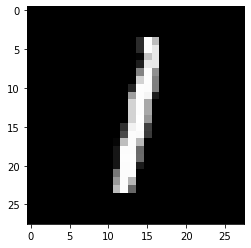

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 

def anomaly_detect_split(images, labels, normals=[1, 3, 5, 7]):
    '''
    normal   = a: 50%, b: 50%
    abnormal = c: 50%, d: 50%
    training   = a
    validation = b + c
    testing    = b + d
    '''
    
    normal_mask     = np.isin(labels, normals)
    normal_labels   = labels[normal_mask]
    normal_images   = images[normal_mask]
    abnormal_labels = labels[np.invert(normal_mask)]
    abnormal_images = images[np.invert(normal_mask)]
    
    normal_shuffler = np.random.permutation(len(normal_labels))
    train_splitter  = normal_shuffler[:int(len(normal_labels)/2)]
    train_labels    = normal_labels[train_splitter]
    train_labels    = (train_labels - 1) / 2 # 1, 3, 5, 7 => 0, 1, 2, 3 | For sparse categorical cross entropy
    train_images    = normal_images[train_splitter]
    
    test_normal_splitter = normal_shuffler[int(len(normal_labels)/2):]
    val_labels           = np.zeros(len(test_normal_splitter))
    val_images           = normal_images[test_normal_splitter]
    test_labels          = np.zeros(len(test_normal_splitter))
    test_images          = normal_images[test_normal_splitter]
    
    abnormal_shuffler     = np.random.permutation(len(abnormal_labels))
    abnormal_val_splitter = abnormal_shuffler[:int(len(abnormal_labels)/2)]
    val_labels            = np.concatenate((val_labels, np.ones(len(abnormal_val_splitter))))
    val_images            = np.concatenate((val_images, abnormal_images[abnormal_val_splitter]))
    abnormal_test_splitter = abnormal_shuffler[int(len(abnormal_labels)/2):]
    test_labels            = np.concatenate((test_labels, np.ones(len(abnormal_test_splitter))))
    test_images            = np.concatenate((test_images, abnormal_images[abnormal_test_splitter]))
    
    # Label preprocessing
    
    
    return (train_images, train_labels, val_images, val_labels, test_images, test_labels)
    
    
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
images = np.concatenate((train_images, test_images))
labels = np.concatenate((train_labels, test_labels))
# Normalize pixel values to be between 0 and 1
images = images / 255.0

(
    train_images, 
    train_labels, 
    val_images, 
    val_labels, 
    test_images, 
    test_labels
) = anomaly_detect_split(images, labels)

print(f'Number of training samples: {train_labels.shape[0]}')
print(f'Number of validation samples: {val_labels.shape[0]}')
print(f'Number of testing samples: {test_labels.shape[0]}')

ds_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).cache().shuffle(train_labels.shape[0]).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)

print()
plt.imshow(train_images[0], cmap='gray')
print(f'Label: {train_labels[0]}')

## Model Design

In [2]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0

## Training

In [3]:
LR = 1e-5
ATH = 0.8 # anomaly confidence threshold
best_classifier = tf.keras.models.clone_model(classifier)
best_acc = 0

In [4]:
class customCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global best_classifier, best_acc
        num_correct = 0
        num_total = 0
        for image, label in ds_val:
            confidence = tf.math.reduce_max(tf.nn.softmax(classifier(image)), 1).numpy()
            num_correct += ((confidence < ATH) == label.numpy()).sum()
            num_total += label.shape[0]
            
        
        print(f"Epoch {epoch+1: 2d}", end='')
        print(
            f"\x1b[32m Train \x1b[0m "
            f"Loss: {logs['loss']: .3f}, "
            f"Top-1: {logs['sparse_categorical_accuracy']: .3f}",
            end = '\t'
        )
        
        acc = num_correct/num_total
        if acc > best_acc:
            best_acc = acc
            best_classifier.set_weights(classifier.get_weights())
        print(f'Anomaly detection accuracy:\x1b[31m {acc: .5f}\x1b[0m')

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)
history = classifier.fit(
    ds_train, 
    epochs=15,
    verbose=0,
    callbacks=[customCallback()]
)

Epoch  1 Train  Loss:  2.118, Top-1:  0.266	Anomaly detection accuracy:  0.59109
Epoch  2 Train  Loss:  1.607, Top-1:  0.418	Anomaly detection accuracy:  0.59109
Epoch  3 Train  Loss:  1.166, Top-1:  0.796	Anomaly detection accuracy:  0.59109
Epoch  4 Train  Loss:  0.882, Top-1:  0.852	Anomaly detection accuracy:  0.59111
Epoch  5 Train  Loss:  0.658, Top-1:  0.866	Anomaly detection accuracy:  0.64006
Epoch  6 Train  Loss:  0.499, Top-1:  0.885	Anomaly detection accuracy:  0.71403
Epoch  7 Train  Loss:  0.393, Top-1:  0.903	Anomaly detection accuracy:  0.72940
Epoch  8 Train  Loss:  0.321, Top-1:  0.918	Anomaly detection accuracy:  0.74206
Epoch  9 Train  Loss:  0.271, Top-1:  0.930	Anomaly detection accuracy:  0.73349
Epoch  10 Train  Loss:  0.234, Top-1:  0.938	Anomaly detection accuracy:  0.72354
Epoch  11 Train  Loss:  0.206, Top-1:  0.945	Anomaly detection accuracy:  0.70757
Epoch  12 Train  Loss:  0.183, Top-1:  0.951	Anomaly detection accuracy:  0.69694
Epoch  13 Train  Loss:  0

## Inference

In [6]:
num_correct = 0
num_total = 0
for image, label in ds_test:
    confidence = tf.math.reduce_max(tf.nn.softmax(best_classifier(image)), 1).numpy()
    num_correct += ((confidence < ATH) == label.numpy()).sum()
    num_total += label.shape[0]
print(f'Anomaly detection accuracy: {num_correct/num_total: .5f}')

Anomaly detection accuracy:  0.74031
